# 结巴

结巴分词支持中英文分词、词性标注和关键词提取三种功能。中文分词采用在基于前缀词典构建的有向无环图（DAG）上，采用动态规划查找最大概率路径的方法找到最可能划分的方式完成。对于未登录词，结巴则采用HMM进行划分。

## 原理说明
首先，结巴从训练数据中统计出离线词典。离线词典的个数如下所示，第一列为词语，第二列为词语的频率，第三列为词性。结巴中的离线词典放在`extra_dict/dict.txt.small`中。

```
通过 35063 p
研究 35029 vn
文化 34860 n
企业 34826 n
```
然后，基于上述统计的离线词典构建前缀词典。对于“清华大学”，这个词的前缀有“清”，“清华”，“清华大”。前缀词典的格式如下所示。其中“清华大”的词频为0，这是因为它没有出现在统计词典中。
```
清华大学 2053
清华大 0
大学 20025
大 144099
学 17482
清华 34488
清 17860
来 480
来到 300
```

其次，基于生成的前缀词典对文本进行切分。例如“我来到北京清华大学”，对于第一个位置的字“我”没有对应的前缀，所以只有一种切分方法。对于第二个位置的字“来”，则有“来”，“来到”两种前缀，所以可能有两种划分方法。对于第三个位置的字“到”，也只有一种划分方法。以此类推，可以得到所有位置的字的前缀。最终可以得到如下所示的有向无环图（DAG）：

```
我-->来-->到-->北-->京-->清-->华-->大-->学
     |---|    |----|    |---|    |---|    
                        |------------|
```
在结巴中，每个文本的前缀划分使用字的位置表示。上述句子对应的前缀标志为：
```
[0]: [0]
[1]: [1, 2]
[2]: [2]
[3]: [3, 4]
[4]: [4]
[5]: [5, 6, 8]
[6]: [6]
[7]: [7, 8]
```


接着，在上述DAG上根据前缀词典对饮的频率，使用动态规划找到概率最大的划分。


## 代码分析

```
.
├── extra_dict
├── jieba
│   ├── __init__.py
│   ├── __main__.py
│   ├── _compat.py
│   ├── analyse
│   ├── dict.txt
│   ├── finalseg
│   └── posseg
└── test
    └── parallel
```

结巴提供分词，未登录词识别，词性标注和关键词提取功能，分别对应`__init__.py, finalseg, posseg和analyse`。

### 分词
结巴的分词使用`Tokenizer`类完成，在`__init__.py`中声明了全局的instance和全局函数。下面对默认分词模式的流程进行分析。
```python
# default Tokenizer instance
dt = Tokenizer()

# global functions
get_FREQ = lambda k, d=None: dt.FREQ.get(k, d)
add_word = dt.add_word
calc = dt.calc
cut = dt.cut
lcut = dt.lcut
...
```

首先，cut函数通过re.split将文本切分为多个以中文字、字母、数字和其他合法字符分隔符的字符串（`re.compile("([\u4E00-\u9FD5a-zA-Z0-9+#&\._%\-]+)", re.U)`）。

其次，逐个处理字符串。如果该字符串包含上述合法字符，则使用`__cut_DAG`函数分词。否则，其他的就是一些换行、其他标点符号，因此直接使用yield将它们分开即可。内部的处理逻辑其实非常的简单，而且代码非常简洁！！！
```python
blocks = re_han.split(sentence)
for blk in blocks:
    if not blk:
        continue
    if re_han.match(blk):
        for word in cut_block(blk):
            yield word
    else:
        tmp = re_skip.split(blk)
        for x in tmp:
            if re_skip.match(x):
                yield x
            elif not cut_all:
                for xx in x:
                    yield xx
            else:
                yield x
```

get_DAG函数首先载入频率词典（self.initialize），生成输入文本的DAG(self.get_DAG)，然后采用动态规划计算概率（self.calc），接着回溯最大概率路径。如果回溯过程中遇到了未登录词，则使用HMM进行划分（finalseg.cut）。

### 有向无环图
结巴第一次从dict.txt文件中读取频率词典，之后则从缓存文件中读取。读取频率词典后，使用`gen_pfdict`函数构造前缀词典，对于在频率词典中没出现的词，设置其频率为0。前缀词典最终存储在`self.FREQ`变量中。
```python
lfreq = {} //前缀词典
for ch in xrange(len(word)):
    wfrag = word[:ch + 1] //构造前缀
    if wfrag not in lfreq:
        lfreq[wfrag] = 0 //设置频率
```

如上所述，在结巴中将有向无环图图表示为所有位置可能成词的最后一个字的下标列表。存储有向无环图的结构其实是一个dict，key为句子中每个字的下标，value则是这个以这个字为开头，这个字之后连续若干字可以成词的最后一个字的下标列表。
```python
def get_DAG(self, sentence):
    self.check_initialized() //生成前缀词典
    DAG = {} //有向无环图
    N = len(sentence)
    for k in xrange(N):
        tmplist = []
        i = k
        frag = sentence[k]
        while i < N and frag in self.FREQ:
            if self.FREQ[frag]: //可以成词，记录下标
                tmplist.append(i)
            i += 1
            frag = sentence[k:i + 1]
        if not tmplist:
            tmplist.append(k)
        DAG[k] = tmplist
    return DAG
```

### 最大概率切分
结巴使用动态规划找到最可能的划分，使用`calc`函数完成。动态规划从后往前遍历，每到达一个节点，那么其到终点的最大概率路径已经找到。`route[x] = (y,z)`表示以x到z为划分词，z到结尾的最大划分概率y。
```python
def calc(self, sentence, DAG, route):
    N = len(sentence)
    # route[x] = (y,z)表示以x到y为划分，[x-y]到结尾的概率
    route[N] = (0, 0) 
    logtotal = log(self.total)
    for idx in xrange(N - 1, -1, -1):
        # 找到最大的概率，max比较元组里面的第一个元素，即概率。
        route[idx] = max((log(self.FREQ.get(sentence[idx:x + 1]) or 1) -
                          logtotal + route[x + 1][0], x) for x in DAG[idx])
```
动态规划从句子的末尾开始的原因有两点：
+ 我们通过DAG可以知道，一个节点可以指向后面哪些节点，但是不知道有哪些节点可以指向这个节点。例如，对于ABCD来说，当我们到达B时，根据DAG可以知道有两种划分`BC/D`和`BCD`，因此可以快速比较`P(BC)*P(D)`和`P(BCD)`的大小。但是如果从前往后，我们无法根据DAG快速知道AB的划分，而是要根据A的结尾位置来确定B的划分，进而才能计算各种划分的概率。其实为了解决这个问题，我们将DAG的存储方法修改为：对于每个位置记录的是以其为结尾的所有可能的第一个字的位置。
+ 另一方面根据汉语的用语习惯，一般重点的词都是在后面的，前面的多为动词、修饰词等，因此从后往前划分的正确率会较高。

对于第二个原因，作者修改默认设置下分词为从前往后，从而验证从后往前划分确实可以提高分词的准确率。
从后往前的划分结果：
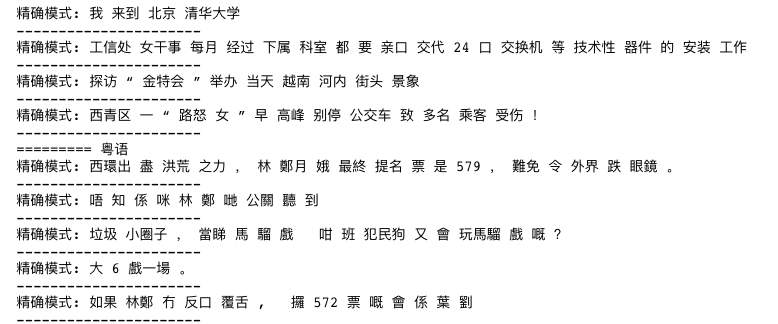

从前往后的划分结果：
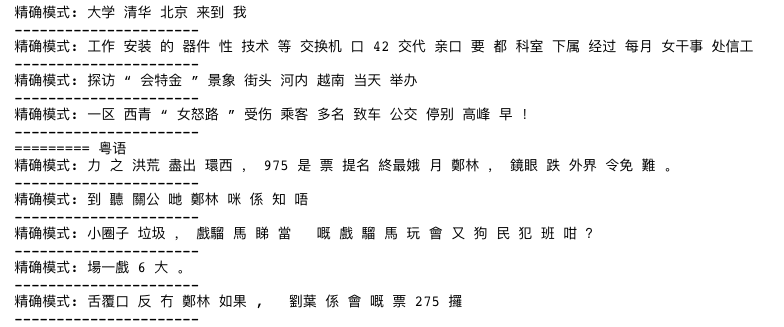

最后，基于得到的最大概率进行回溯得到划分。假设划分得到的词没有出现在词典中，则使用HMM继续划分。

### 未登录词识别
结巴使用HMM处理未登录词，对于在词典中没有出现过的字符串传入HMM进行划分。

结巴中的模型是提前训练好的，模型的相关参数存放在`finalseg/prob*.py`文件中。根据[作者的解释](https://github.com/fxsjy/jieba/issues/7)，这些模型参数使用1998人民日报切分语料、MSR切分语料以及作者自己下载的小说作为训练数据集从而训练得到。

HMM中使用`[B, M, E, S]`分别表示词语的开头、中间、结尾和单字成词。对于传入的字符串，结巴直接调用已经训练好的模型（包括初始概率、状态转移概率和输出概率），使用viterbi算法估计每个字对应的隐状态。
```python
def viterbi(obs, states, start_p, trans_p, emit_p):
    V = [{}]  # 每个时刻t来自各个state的概率
    path = {} # 对于当前时刻，它的各种状态的来源路径
    for y in states:  # 初始化
        # 第1个位置的初始状态概率+生成第一个字的概率
        V[0][y] = start_p[y] + emit_p[y].get(obs[0], MIN_FLOAT)
        # 第1个位置每个状态的来源路径，即就是初始状态
        path[y] = [y]
    for t in xrange(1, len(obs)):
        V.append({})
        newpath = {}
        for y in states:
            em_p = emit_p[y].get(obs[t], MIN_FLOAT)
            # PrevStatus 存储每种状态可能的前一种状态
            (prob, state) = max(
                [(V[t - 1][y0] + trans_p[y0].get(y, MIN_FLOAT) + em_p, y0) for y0 in PrevStatus[y]])
            V[t][y] = prob
            newpath[y] = path[state] + [y]
        path = newpath
    ## 假设最后一个字只能是末尾字或者单字成词
    (prob, state) = max((V[len(obs) - 1][y], y) for y in 'ES')

    return (prob, path[state])
```

最后，根据得到的概率和路径回溯得到词语切分。


### 搜索引擎模式分词
结巴对搜索引擎模式分词的解释为
> 搜索引擎模式，在精确模式的基础上，对长词再次切分，提高召回率，适合用于搜索引擎分词。

实际上，所谓对长词再次切分其实是对于长度大于2和大于3的词语，构建2-gram和3-gram词元。如果词语在频率词典中则同时返回这个词语。
```python
def cut_for_search(self, sentence, HMM=True):
    """
    Finer segmentation for search engines.
    """
    words = self.cut(sentence, HMM=HMM)
    for w in words:
        if len(w) > 2:
            for i in xrange(len(w) - 1):
                gram2 = w[i:i + 2]
                if self.FREQ.get(gram2):
                    yield gram2
        if len(w) > 3:
            for i in xrange(len(w) - 2):
                gram3 = w[i:i + 3]
                if self.FREQ.get(gram3):
                    yield gram3
        yield w
```




### 细节分析
+ 前缀词典
其实前缀词典相当于另一种Trie树的实现，因为lfreq中存储了所有词语可能构成的前缀，从而导致占用空间非常大。

+ 自定义词典
如果使用`jieba.add_word(word)`方法增加自定义的词语，那么最终的分词结果并不一定会将这个词语分开。这是因为增加的这个词会跟其他所有可能的切分共同竞争，最终还是选择概率最大的切分。为了解决这个问题可以给增加的词设置一个比较大的频次，如`jieba.add_word(word, 123456)`。另外一种解决方法是使用`jieba.suggest_freq(word, tune=True)`方法自动调整词语的概率。不过第二种方法只在可能分词频次上增加了1，并且存在计算转换的问题，因此有可能还是不能分对。

另外，由于add_word方法增加了self.total，从而使得词典中原来词语的频率下降，因此可能导致原来可以分对的词语最终分错。

+ 让词语分开
与自定义词典相反，有时候可能希望让词语分开，这是可以使用suggest_freq函数:
> jieba.suggest_freq(('中', '将'), True)


+ 并行分词
结巴的并行分词的原理其实就是：调用**多进程**的方法分词，每个进程分`total_lines/n_process`行文本，最后进行merge。
> 是多进程，不是多线程。我开始也想用多线程，但是后来发现Python对于CPU密集型的任务，在多线程下也不能利用多核CPU。因此，我才改为多进程实现的。


+ HMM模型
结巴中的HMM模型是已经训练好的，并且不支持自己训练。


## 参考
[HMM模型的数据是如何生成的？](https://github.com/fxsjy/jieba/issues/7)